In [113]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import copy

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
%matplotlib tk

## Making Class for Soft But Hard Decision Tree - Static Building/End2End

We clip the gradient of straight through sigmoid; this allows gradient to pass through constant(ish) part of sigmoid

In [92]:
class LeafNode(object):
    
    def __init__(self, output_dim, optimizer):
        self.output_dim = output_dim
        self.optimizer = optimizer
        self.constant = tnn.BiasLayer(self.output_dim, optimizer=self.optimizer)
        
    def forward(self, inputs):
        out = np.zeros(shape=(inputs.shape[0], self.output_dim))
        return self.constant.forward(out)
    
    def backward(self, del_outputs):
        self.constant.backward(del_outputs)
        return del_outputs
    
    def update(self):
        self.constant.update()

class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.node0 = None
        self.node1 = None
        self.linear = tnn.LinearLayer(input_dim, output_dim, optimizer=optimizer)
        self.linear.weights *= 0
        self.sigmoid = tnn.Sigmoid()
        
        self.mask = None
        self.out0 = None
        self.out1 = None
        
    def forward(self, inputs):
        lout = self.linear.forward(inputs)
        self.sigmoid.forward(lout)
        
        self.mask = (lout>0).astype(lout.dtype)
        self.out0 = self.node0.forward(inputs)
        self.out1 = self.node1.forward(inputs)
        
        return self.out0*self.mask + self.out1*(1-self.mask)
    
    def backward(self, del_outputs):
        del_out0 = del_outputs*self.mask
        del_out1 = del_outputs*(1-self.mask)
        
        self.node0.backward(del_out0)
        self.node1.backward(del_out1)
        
        grad = del_outputs.mean(axis=1, keepdims=True)
        virtual_targ = np.clip(self.sigmoid.out-grad, 0, 1)
        bce_grad = self.sigmoid.out - virtual_targ
        
        sig_grad = self.sigmoid.backward(grad)
        
        self.linear.backward(sig_grad*0.8+bce_grad*0.2)
#         self.linear.backward(sig_grad+grad*0.2+bce_grad*0.2)
        return del_outputs
    
    def update(self):
        self.linear.update()
        self.node0.update()
        self.node1.update()
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node1 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self.output_dim, self.optimizer)
            self.node1 = LeafNode(self.output_dim, self.optimizer)

## 1D regression

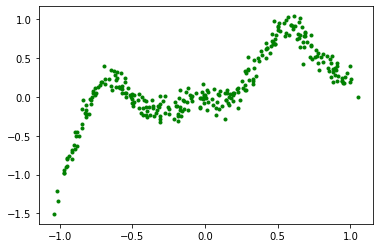

In [99]:
np.random.seed(12)
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [100]:
optimizer = tnn.Adam()
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=3)

In [101]:
yout = hdt.forward(xx)

In [102]:
xx.shape, yout.shape

((300, 1), (300, 1))

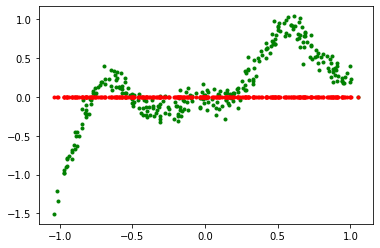

In [103]:
%matplotlib inline

plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), marker='.', color='r')
plt.show()

In [104]:
optimizer = tnn.Adam(0.01)
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=3)

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, yout.reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.20385006202675826


100 Error =  0.12345831926464575


200 Error =  0.10169477618062325


300 Error =  0.08158756985550598


400 Error =  0.06076931736928925


500 Error =  0.05268207176663833


600 Error =  0.04922181832601092


700 Error =  0.04938170292557943


800 Error =  0.048643340163228764


900 Error =  0.046467244493649626


1000 Error =  0.04470823655843216


1100 Error =  0.04333238073494776


1200 Error =  0.04312250189833185


1300 Error =  0.04255009888337415


1400 Error =  0.04220717458954192


1500 Error =  0.040793262857490464


1600 Error =  0.04074912397334353


1700 Error =  0.04123978299175863


1800 Error =  0.04159859835782759


1900 Error =  0.04160048409493356


2000 Error =  0.04283678148910807


2100 Error =  0.04209862594938139


2200 Error =  0.04197484483106503


2300 Error =  0.042577792006727185


2400 Error =  0.042495890067510506


2500 Error =  0.041877772041775646


2600 Error =  0.0425798414166243


2700 Error =  0.042129913204951706


TclError: invalid command name "pyimage197"

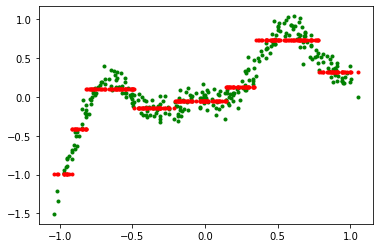

In [105]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), color='r', marker='.')

## On 2D dataset

In [106]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [107]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

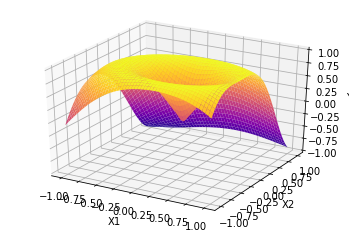

In [108]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [109]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Building Decision Tree

In [110]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=3)

In [111]:
yout = hdt.forward(xx)

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise D

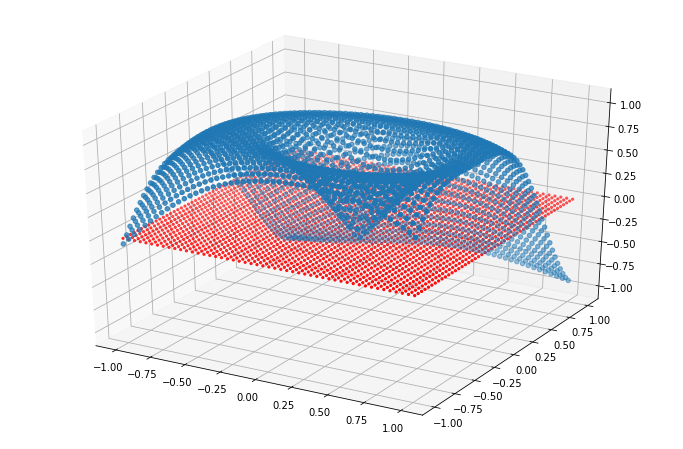

In [114]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()

In [115]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=3)

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5639648664243325


100 Error =  0.08508666613044218


200 Error =  0.06950968208842928


300 Error =  0.07909145356058407


400 Error =  0.08046153351354225


500 Error =  0.08151074407053496


600 Error =  0.07346567309967261


700 Error =  0.06164019539547937


800 Error =  0.05673910223704813


900 Error =  0.054820208542934526


1000 Error =  0.05150900177686308


1100 Error =  0.04746900813499436


1200 Error =  0.043203435549225705


1300 Error =  0.03982016738795522


1400 Error =  0.04005911140022604


1500 Error =  0.04133295533052897


1600 Error =  0.04153124903363312


1700 Error =  0.041682970253844084


1800 Error =  0.041299056772116836


1900 Error =  0.04086884200189619


2000 Error =  0.040343332227591705


2100 Error =  0.04007361603822188


2200 Error =  0.0398531852216988


2300 Error =  0.04017002996354538


2400 Error =  0.04130748182503584


2500 Error =  0.041963268909399144


2600 Error =  0.04147463208089775


2700 Error =  0.04231381903509214




TclError: invalid command name "pyimage227"

/home/tsuman/Program_Files/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


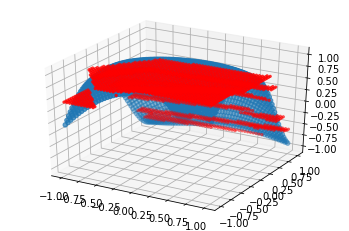

In [21]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()

## Vanilla Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(max_depth=4)

In [ ]:
dtr.fit(xx, yy)

In [ ]:
yout = dtr.predict(xx)

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()